In [20]:
from pandas import read_csv, get_dummies, DataFrame
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import datetime

In [2]:
features = read_csv('Desktop/rf-data-sample/temps.csv')
features.head(5)

year  month  day  week  temp_2  temp_1  average  actual  friend
0  2016      1    1   Fri      45      45     45.6      45      29
1  2016      1    2   Sat      44      45     45.7      44      61
2  2016      1    3   Sun      45      44     45.8      41      56
3  2016      1    4   Mon      44      41     45.9      40      53
4  2016      1    5  Tues      41      40     46.0      44      41

In [3]:
features.describe()

year       month         day      temp_2      temp_1     average  \
count   348.0  348.000000  348.000000  348.000000  348.000000  348.000000   
mean   2016.0    6.477011   15.514368   62.511494   62.560345   59.760632   
std       0.0    3.498380    8.772982   11.813019   11.767406   10.527306   
min    2016.0    1.000000    1.000000   35.000000   35.000000   45.100000   
25%    2016.0    3.000000    8.000000   54.000000   54.000000   49.975000   
50%    2016.0    6.000000   15.000000   62.500000   62.500000   58.200000   
75%    2016.0   10.000000   23.000000   71.000000   71.000000   69.025000   
max    2016.0   12.000000   31.000000   92.000000   92.000000   77.400000   

           actual      friend  
count  348.000000  348.000000  
mean    62.543103   60.034483  
std     11.794146   15.626179  
min     35.000000   28.000000  
25%     54.000000   47.750000  
50%     62.500000   60.000000  
75%     71.000000   71.000000  
max     92.000000   95.000000

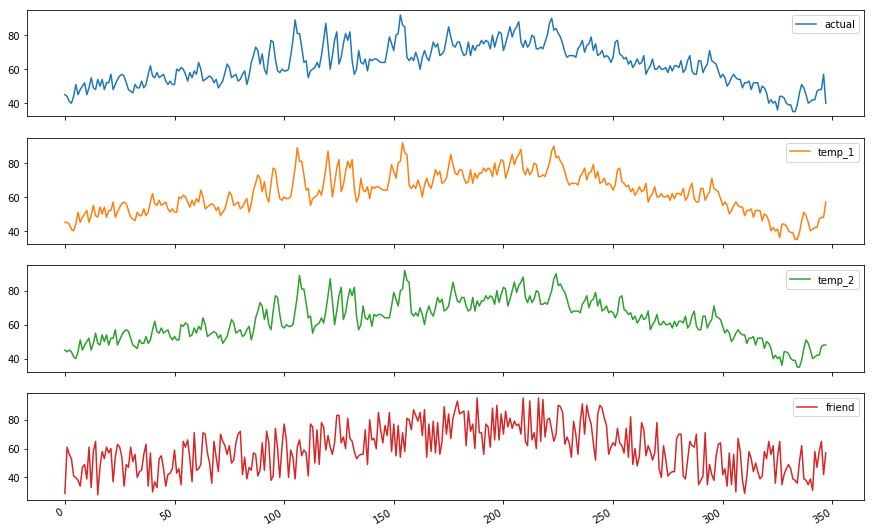

In [4]:

features.plot(y=['actual', 'temp_1','temp_2', 'friend'], subplots=True, figsize=(15,10))
plt.show()

In [5]:
features = get_dummies(features)

features.iloc[:,5:].head(5)

average  actual  friend  week_Fri  week_Mon  week_Sat  week_Sun  \
0     45.6      45      29         1         0         0         0   
1     45.7      44      61         0         0         1         0   
2     45.8      41      56         0         0         0         1   
3     45.9      40      53         0         1         0         0   
4     46.0      44      41         0         0         0         0   

   week_Thurs  week_Tues  week_Wed  
0           0          0         0  
1           0          0         0  
2           0          0         0  
3           0          0         0  
4           0          1         0

In [6]:
labels = np.array(features['actual'])
features= features.drop('actual', axis = 1)
feature_list = list(features.columns)
features = np.array(features)

In [7]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [8]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (261, 14)
Training Labels Shape: (261,)
Testing Features Shape: (87, 14)
Testing Labels Shape: (87,)


In [9]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('average')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))


Average baseline error:  5.06


In [10]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_features, train_labels);

In [11]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 3.83 degrees.


In [12]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


Accuracy: 93.99 %.


In [13]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization

# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [14]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: temp_1               Importance: 0.7
Variable: average              Importance: 0.19
Variable: day                  Importance: 0.03
Variable: temp_2               Importance: 0.02
Variable: friend               Importance: 0.02
Variable: month                Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


In [16]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('temp_1'), feature_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.92 degrees.
Accuracy: 93.77 %.


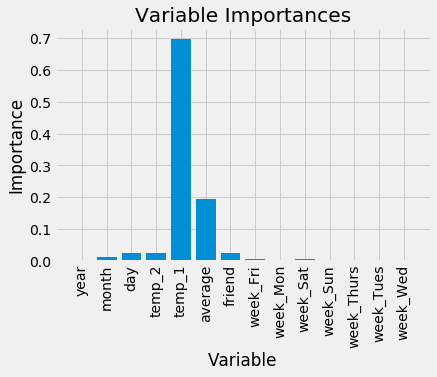

In [17]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

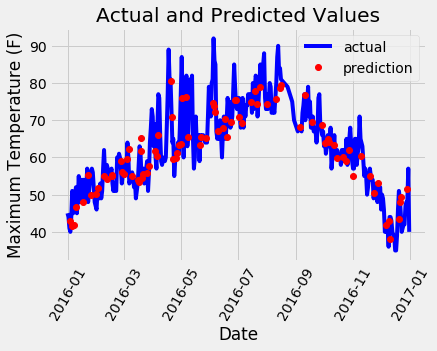

In [22]:

# Dates of training values
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]
# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
# Dataframe with true values and dates
true_data = DataFrame(data = {'date': dates, 'actual': labels})
# Dates of predictions
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]
# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
# Dataframe with predictions and dates
predictions_data = DataFrame(data = {'date': test_dates, 'prediction': predictions})
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

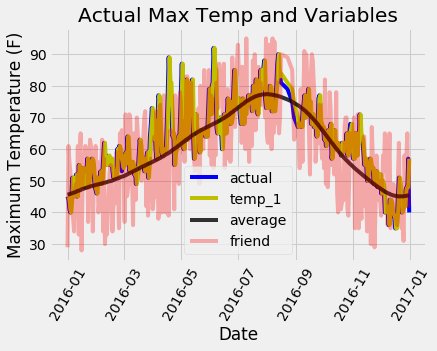

In [23]:
# Make the data accessible for plotting
true_data['temp_1'] = features[:, feature_list.index('temp_1')]
true_data['average'] = features[:, feature_list.index('average')]
true_data['friend'] = features[:, feature_list.index('friend')]
# Plot all the data as lines
plt.plot(true_data['date'], true_data['actual'], 'b-', label  = 'actual', alpha = 1.0)
plt.plot(true_data['date'], true_data['temp_1'], 'y-', label  = 'temp_1', alpha = 1.0)
plt.plot(true_data['date'], true_data['average'], 'k-', label = 'average', alpha = 0.8)
plt.plot(true_data['date'], true_data['friend'], 'r-', label = 'friend', alpha = 0.3)
# Formatting plot
plt.legend(); plt.xticks(rotation = '60');
# Lables and title
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual Max Temp and Variables');